In [5]:
import zipfile
z = zipfile.ZipFile("dl_models\archive.zip")
z.extractall()

FileNotFoundError: [Errno 2] No such file or directory: 'dl_models\\archive.zip'

In [1]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [2]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    data=[]
    for label in labels:
#         train/PNEUMONIA
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

In [3]:
train = get_data(r"C:\Users\Arunava Chakraborty\Desktop\HUMAN_DISEASE_PREDICTION\dl_models\Pnumonia_detection\chest_xray\train")
test = get_data(r"C:\Users\Arunava Chakraborty\Desktop\HUMAN_DISEASE_PREDICTION\dl_models\Pnumonia_detection\chest_xray\test")
val = get_data(r"C:\Users\Arunava Chakraborty\Desktop\HUMAN_DISEASE_PREDICTION\dl_models\Pnumonia_detection\chest_xray\val")


In [4]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/train/PNEUMONIA"

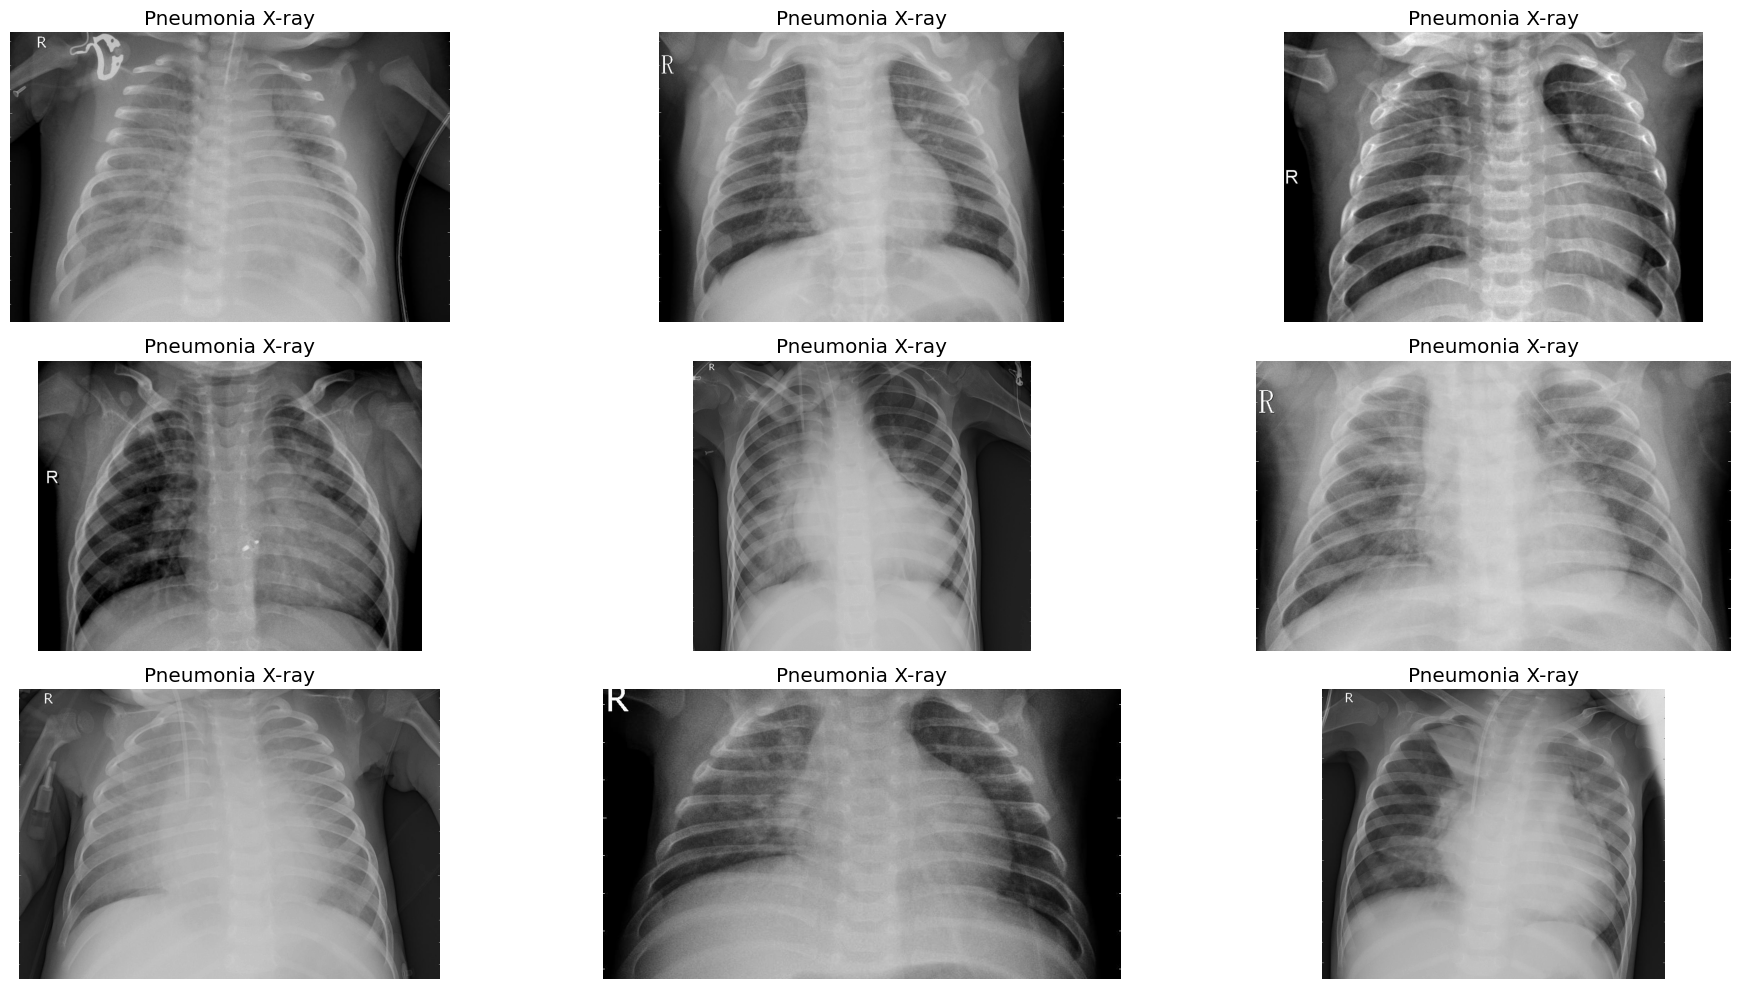

In [19]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [5]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

NameError: name 'normal_dir' is not defined

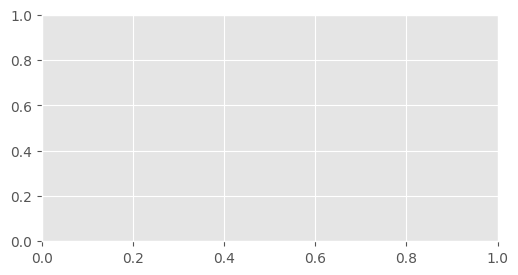

In [18]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

5216

<Axes: xlabel='count'>

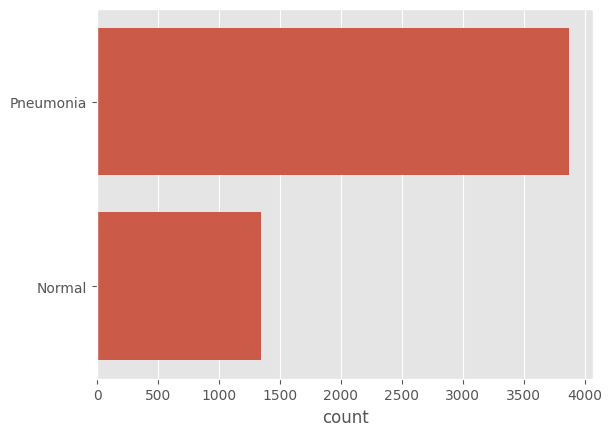

In [16]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [9]:
# Data Augmentation & Resizing

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
train_generator = train_datagen.flow_from_directory("chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [9]:
class_labels = train_generator.class_indices

In [10]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
class_name = {value:key for (key, value) in class_labels.items()}

In [12]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [17]:
# VGG19 CNN Architecture

In [14]:
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [15]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

# sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0, nesterov = True)

model_01.compile(loss="categorical_crossentropy",optimizer='adam', metrics=['accuracy'])

In [17]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=10,
            epochs=5, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/5
10/10 [==============================] - 20s 2s/step - loss: 0.6143 - accuracy: 0.7125 - val_loss: 0.6683 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 23s 2s/step - loss: 0.4319 - accuracy: 0.8062 - val_loss: 0.6006 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 24s 2s/step - loss: 0.4577 - accuracy: 0.7812 - val_loss: 0.7725 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 24s 2s/step - loss: 0.3170 - accuracy: 0.8687 - val_loss: 1.1146 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - ETA: 0s - loss: 0.3523 - accuracy: 0.8281
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10/10 [==============================] - 24s 2s/step - loss: 0.3523 - accuracy: 0.8281 - val_loss: 0.7932 - val_accuracy: 0.6250 - lr: 0.0010


In [18]:
import os

# Create directory if it doesn't exist
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')

# Save the model
model_01.save(filepath="model_weights/avi_vgg19_model_01.h5", overwrite=True)


c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Reload model in old TF environment if possible
model = load_model(r'C:\Users\Arunava Chakraborty\Desktop\HUMAN_DISEASE_PREDICTION\dl_models\Pnumonia_detection\model_weights\avi_vgg19_model_01.h5')

# Re-save in new format
model.save('avi_vgg19_model_01_new.keras')  # Recommended extension in TF 2.16+


In [6]:
from tensorflow.keras.models import load_model
model = load_model("model.keras")


ImportError: cannot import name 'cond' from 'keras.src.backend' (c:\Users\Arunava Chakraborty\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py)

In [5]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model_pneumonia = load_model(r'C:\Users\Arunava Chakraborty\Desktop\HUMAN_DISEASE_PREDICTION\dl_models\Pnumonia_detection\avi_vgg19_model_01_new.keras')
print("✅ Model loaded.")

img = cv2.imread(r"C:\Users\Arunava Chakraborty\Desktop\HUMAN_DISEASE_PREDICTION\static\uploads\medical_records\b.jpg", cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_resized = cv2.resize(img_rgb, (128, 128)) / 255.0
img_resized = np.reshape(img_resized, (1, 128, 128, 3))

prediction = model_pneumonia.predict(img_resized)
predicted_class = np.argmax(prediction, axis=1)[0]
prediction_label = 'NORMAL' if predicted_class == 0 else 'PNEUMONIA'
result = f'The model predicts: {prediction_label}'

print("Prediction output:", result)


✅ Model loaded.
1/1 [==============================] - 0s 245ms/step
Prediction output: The model predicts: PNEUMONIA


In [31]:
test_generator = test_datagen.flow_from_directory("chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [33]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - accuracy: 0.7500 - loss: 0.7601
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8034 - loss: 0.4848


In [34]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.7601194381713867
Validation Accuarcy: 0.75
Test Loss: 0.4643521308898926
Test Accuarcy: 0.8237179517745972


In [28]:
# Increamental unfreezing & fine tuning

In [33]:
# base_model = VGG19(include_top=False, input_shape=(128,128,3))
# base_model_layer_names = [layer.name for layer in base_model.layers]

# x = base_model.output
# flat = Flatten()(x)


# class_1 = Dense(4608, activation = 'relu')(flat)
# dropout = Dropout(0.2)(class_1)
# class_2 = Dense(1152, activation = 'relu')(dropout)
# output = Dense(2, activation = 'softmax')(class_2)

# model_02 = Model(base_model.inputs, output)
# model_02.load_weights("model_weights/vgg19_model_01.h5")

# set_trainable = False
# for layer in base_model.layers:
#     if layer.name in [ 'block5_conv3','block5_conv4']:
#         set_trainable=True
#     if set_trainable:
#         set_trainable=True
#     else:
#         set_trainable=False
# print(model_02.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [32]:
# base_model_layer_names

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [34]:
# sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0, nesterov = True)

# model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [35]:
# history_02 = model_02.fit(train_generator, 
#             steps_per_epoch=10,
#             epochs=1, 
#             callbacks=[es, cp, lrr],
#             validation_data=valid_generator)

10/10 [==============================] - 106s 10s/step - loss: 0.3809 - accuracy: 0.8375 - val_loss: 0.5210 - val_accuracy: 0.7500 - lr: 1.0000e-04


In [36]:
# if not os.path.isdir('model_weights/'):
#     os.mkdir("model_weights/")
# model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [37]:
# model_02.load_weights("model_weights/vgg19_model_02.h5")

# vgg_val_eval_02 = model_02.evaluate(valid_generator)
# vgg_test_eval_02 = model_02.evaluate(test_generator)

# print(f"Validation Loss: {vgg_val_eval_02[0]}")
# print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
# print(f"Test Loss: {vgg_test_eval_02[0]}")
# print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

20/20 [==============================] - 45s 2s/step - loss: 0.5646 - accuracy: 0.7564
Validation Loss: 0.9507322311401367
Validation Accuarcy: 0.6875
Test Loss: 0.564642071723938
Test Accuarcy: 0.7564102411270142


In [38]:
# Unfreezing and fine tuning the entire network

In [39]:
# base_model = VGG19(include_top=False, input_shape=(128,128,3))

# x = base_model.output
# flat = Flatten()(x)

# class_1 = Dense(4608, activation = 'relu')(flat)
# dropout = Dropout(0.2)(class_1)
# class_2 = Dense(1152, activation = 'relu')(dropout)
# output = Dense(2, activation = 'softmax')(class_2)

# model_03 = Model(base_model.inputs, output)
# model_03.load_weights("model_weights/vgg19_model_01.h5")

# print(model_03.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [40]:
# sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum=0, nesterov = True)

# model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [ ]:
# history_03 = model_02.fit(train_generator, 
#             steps_per_epoch=100,
#             epochs=1, 
#             callbacks=[es, cp, lrr],
#             validation_data=valid_generator)

In [ ]:
# if not os.path.isdir('model_weights/'):
#     os.mkdir("model_weights/")
# model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)